In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [4]:
class Mymodel(nn.Module):
  def __init__(self):
    super(Mymodel,self).__init__()
    self.features=nn.Sequential(
        nn.Conv2d(1,32,3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32,64,3),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fcl=nn.Sequential(
        nn.Linear(64 * 5 * 5, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
  def forward(self,x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.fcl(x)
    return x

In [5]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

In [6]:
train_dataset=torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset=torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 167285816.43it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105703048.71it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 162585311.53it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21846936.66it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [9]:
train_loader=DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
#initialization
model=Mymodel()
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
def train(model, optimizer, criterion, train_loader, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Train Epoch: {epoch}, Loss: {running_loss / len(train_loader)}')

def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy}%')


In [14]:
for epoch in range(10):
    train(model, optimizer, criterion, train_loader, epoch)
    test(model, test_loader)


Train Epoch: 0, Loss: 0.2997346512361694
Test Accuracy: 94.77%
Train Epoch: 1, Loss: 0.1611298845012559
Test Accuracy: 96.7%
Train Epoch: 2, Loss: 0.11526624856790754
Test Accuracy: 97.44%
Train Epoch: 3, Loss: 0.09176152368246922
Test Accuracy: 97.74%
Train Epoch: 4, Loss: 0.07740650611963354
Test Accuracy: 98.04%
Train Epoch: 5, Loss: 0.06796218168689434
Test Accuracy: 98.15%
Train Epoch: 6, Loss: 0.061439022861931446
Test Accuracy: 98.09%
Train Epoch: 7, Loss: 0.055676770311639284
Test Accuracy: 98.31%
Train Epoch: 8, Loss: 0.05102446494000489
Test Accuracy: 98.4%
Train Epoch: 9, Loss: 0.047375262186957846
Test Accuracy: 98.58%


#prediction on custom dataset

first save the trained model

In [58]:
#saving our model
from pathlib import Path
#1.create model directory
MODEL_PATH=Path("models")#save models to models file
MODEL_PATH.mkdir(parents=True,exist_ok=True)

#2.create model save path
MODEL_NAME="model1"
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

#save the model state dict in the models folder we made using upper snippet
print(f"saving model to:{MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),f=MODEL_SAVE_PATH)

saving model to:models/model1


In [59]:
loaded_model_1=Mymodel()
#load the saved state space(this will update the new instance with updated parameter)
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

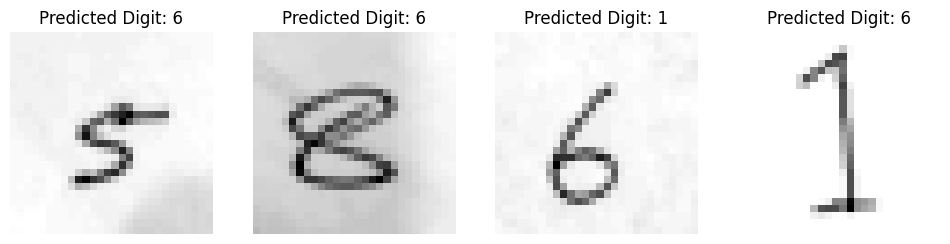

In [62]:
from PIL import Image
import matplotlib.pyplot as plt

# Load your model
model2 = loaded_model_1

# Define a function to preprocess an image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    transform = transforms.Compose([
        transforms.Resize((28, 28)),  # Resize to 28x28
        transforms.ToTensor(),  # Convert to a PyTorch tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize
    ])
    image = transform(image)
    image = image.view(1, 1, 28, 28)  # Add batch and channel dimensions
    return image

# Define a function to make predictions
def predict_digit(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        model.eval()  # Set the model in evaluation mode
        output = model2(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

# Provide the paths to the images you want to predict
image_paths = ['/content/5.jpg', '/content/8.jpg', '/content/6.jpg', '/content/1.png']
predicted_digits = []

# Process and predict each image
for image_path in image_paths:
    predicted_digit = predict_digit(image_path)
    predicted_digits.append(predicted_digit)

# Plot the images and their predicted digits
plt.figure(figsize=(12, 4))
for i, image_path in enumerate(image_paths):
    plt.subplot(1, len(image_paths), i + 1)
    image = preprocess_image(image_path).squeeze(0)  # Remove batch dimension
    image = image / 2.0 + 0.5  # Unnormalize for visualization
    image = transforms.ToPILImage()(image)
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted Digit: {predicted_digits[i]}')
    plt.axis('off')

plt.show()
